In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import matplotlib as mpl
mpl.rcParams['text.usetex'] = True
from IPython.display import display

# Read in the data
- `df_reg_compact`: Compact regular season game results
- `df_conference_info`: List of conferences and teams for each season with unique identifiers
- `df_conferences`: List of conferences with their real names

In [2]:
fp_data = "../../2022/"
df_reg_compact = pd.read_csv(fp_data + 'MDataFiles_Stage2/MRegularSeasonCompactResults.csv')
df_conference_info = pd.read_csv(fp_data + 'MDataFiles_Stage2/MTeamConferences.csv')
df_conferences = pd.read_csv(fp_data + 'MDataFiles_Stage2/Conferences.csv')

In [3]:
# Combine Pac10+Pac12 and Big10+Big12 and add conference groups
df_conferences = df_conferences.append(pd.DataFrame([['pac_tentwelve', 'Pac 12']], columns=['ConfAbbrev','Description']))
df_conferences = df_conferences.append(pd.DataFrame([['big_eighttwelve', 'Big 12']], columns=['ConfAbbrev','Description']))
df_conferences = df_conferences.append(pd.DataFrame([['power_five', 'Power 5']], columns=['ConfAbbrev','Description']))
df_conferences = df_conferences.append(pd.DataFrame([['group_of_five', 'Group of 5']], columns=['ConfAbbrev','Description']))

# For LaTeX rendering
conf_tex_names = {
    'a_sun': "${\\rm Atlantic~Sun~Conference}$",
    'a_ten': "${\\rm Atlantic~10~Conference}$",
    'aac': "${\\rm AAC}$",  #"${\\rm American~Athletic~Conference}$",
    'acc': "${\\rm ACC}$",
    'aec': "${\\rm American~East~Conference}$",
    'asc': "${\\rm American~South~Conference}$",
    'awc': "${\\rm American~West~Conference}$",
    'big_east': "${\\rm Big~East}$",
    'big_eight': "${\\rm Big~8~(old)}$",
    'big_sky': "${\\rm Big~Sky~Conference}$",
    'big_south': "${\\rm Big~South~Conference}$",
    'big_ten': "${\\rm Big~10}$",
    'big_twelve': "${\\rm Big~12~(old)}$",
    'big_west': "${\\rm Big~West}$",
    'mac': "${\\rm MAC}$",
    'ovc': "${\\rm Ohio Valley}$",  #"${\\rm Ohio~Valley~Conference}$",
    'pac_tentwelve': "${\\rm Pac~12}$",
    'pac_twelve': "${\\rm Pac~12}$",
    'pac_ten': "${\\rm Pac~10}$",
    'sec': "${\\rm SEC}$",
    'big_eighttwelve': "${\\rm Big~12}$",
    'ivy': "${\\rm Ivy}$",
    'power_five': "${\\rm Power~5}$",
    'group_of_five': "${\\rm Group~of~5}$",
    'swac': "${\\rm SWAC}$",
    'southland': "${\\rm Southland}$",
    'meac': "${\\rm MEAC}$",
}
df_conferences = df_conferences.reset_index(drop=True)

df_conferences['TexName'] = ""
for conf in conf_tex_names.keys():
    index = df_conferences.index[df_conferences['ConfAbbrev'] == conf].tolist()[0]
    df_conferences.loc[index,'TexName'] = conf_tex_names[conf]
display(df_conferences.head())

,ConfAbbrev,Description,TexName
0,a_sun,Atlantic Sun Conference,${\rm Atlantic~Sun~Conference}$
1,a_ten,Atlantic 10 Conference,${\rm Atlantic~10~Conference}$
2,aac,American Athletic Conference,${\rm AAC}$
3,acc,Atlantic Coast Conference,${\rm ACC}$
4,aec,America East Conference,${\rm American~East~Conference}$


In [6]:
# Split the dataframe into individual seasons and then only consider in-conference games. This is a little slow
def addConf(season, team_id):
    """
    Helper function to add conference abbreviation to dataframe from season and TeamID
    
    :param season: Season year
    :type season: int
    
    :param team_id: Unique TeamID
    :type team_id: int
    
    :return: Conference abbreviation
    :rtype: str
    """
    conf = df_conference_info[(df_conference_info['Season'] == season) & (df_conference_info['TeamID'] == team_id)]
    return conf['ConfAbbrev'].values[0]

df_inconf = {}
for season in range(1985,2023):
    print season
    df_season = df_reg_compact[df_reg_compact['Season'] == season]
    df_season = df_season.reset_index(drop=True)
    df_season['WTeamConf'] = df_season.apply(lambda row: addConf(season, row['WTeamID']), axis=1)
    df_season['LTeamConf'] = df_season.apply(lambda row: addConf(season, row['LTeamID']), axis=1)
    df_inconf[season] = df_season[(df_season['WTeamConf'] == df_season['LTeamConf'])]

1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022


In [7]:
# Compute score differentials
# The data are given with "Winning team score" and "Winning team location," where neutral site is an
#  option for the location. There's no "home team" at neutral sites, but the distribution of score 
#  differentials is still interesting. What we'll actually do is duplicate the dataframe so we have the
#  score differential from both the home team and away team's perspectives, and this will force the 
#  neutral site distributions to by symmetric.
years_list = range(1985,2023)
for year in years_list:
    print year
    df_inconf[year]['ScoreDifferential'] = df_inconf[year]['WScore'] - df_inconf[year]['LScore']
    # Actually duplicate the data then combine
    df_copy = df_inconf[year].copy(deep=True)
    df_copy['ScoreDifferential'] = -df_copy['ScoreDifferential']
    df_copy['WLoc'] =  df_copy.apply(lambda row: 'H' if row['WLoc'] == 'A' else ('A' if row['WLoc'] == 'H' else 'N'), axis=1)
    df_inconf[year] = pd.concat([df_inconf[year],df_copy])

1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022


/anaconda3/envs/astroconda/lib/python2.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [8]:
# Summarize into a dictionary of arrays for quick access
vals = {}
years = range(1985,2023)
for year in years:
    vals[year] = df_inconf[year][df_inconf[year]['WLoc'] == 'H']['ScoreDifferential']

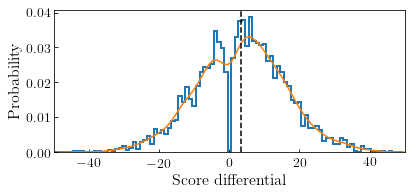

Mean: 3.38


In [9]:
# Example score differential distribution for 2020
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['font.size'] = 16
mpl.rcParams['legend.fontsize'] = 14

# Distribution of score differentials for the 2020 season
fig,ax = plt.subplots(1,1,figsize=(6,3))
bins = np.arange(-50.5,50.5,1)
xs = np.linspace(-50,50,100)
kernel = stats.gaussian_kde(vals[2020])
ax.hist(vals[2020], bins=bins, density=True, histtype='step', lw=2)
ax.plot(xs, kernel(xs))
ax.axvline(np.mean(vals[2020]), color='k', ls='dashed')
ax.set_xlim(xs[0],xs[-1])
ax.set_xlabel("${\\rm Score~differential}$")
ax.set_ylabel("${\\rm Probability}$")
plt.tight_layout()
plt.savefig("../figs/score_differential_2020.pdf")
plt.show()
print "Mean: %.2f" % np.mean(vals[2020])

In [10]:
# LaTeX table of measured score differentials
year_list = range(1985,2023)
num_cols = 5
nrows = int(np.ceil(float(len(year_list))/num_cols))
for i in range(nrows):
    col_years = [nrows * j + year_list[i] for j in range(num_cols)]
    line = ""
    for j in range(len(col_years)):
        year = col_years[j]
        if year > year_list[-1]:
            line += " &"
        elif year < 2000:
            line += "%i-%02d & $%.2f \\pm %.2f$" % (year-1, year-1900, np.mean(vals[year]), np.std(vals[year])/np.sqrt(len(vals[year])))
        else:
            line += "%i-%02d & $%.2f \\pm %.2f$" % (year-1, year-2000, np.mean(vals[year]), np.std(vals[year])/np.sqrt(len(vals[year])))
        if j == num_cols-1:
            line += " \\\\"
        else:
            line += " & "
    print line

1984-85 & $3.86 \pm 0.26$ & 1992-93 & $4.12 \pm 0.27$ & 2000-01 & $4.34 \pm 0.25$ & 2008-09 & $3.42 \pm 0.24$ & 2016-17 & $2.88 \pm 0.24$ \\
1985-86 & $3.90 \pm 0.26$ & 1993-94 & $3.98 \pm 0.27$ & 2001-02 & $4.29 \pm 0.25$ & 2009-10 & $3.45 \pm 0.23$ & 2017-18 & $3.43 \pm 0.24$ \\
1986-87 & $3.92 \pm 0.28$ & 1994-95 & $3.64 \pm 0.27$ & 2002-03 & $4.02 \pm 0.25$ & 2010-11 & $3.33 \pm 0.23$ & 2018-19 & $3.12 \pm 0.24$ \\
1987-88 & $4.63 \pm 0.28$ & 1995-96 & $3.67 \pm 0.27$ & 2003-04 & $3.87 \pm 0.25$ & 2011-12 & $3.69 \pm 0.24$ & 2019-20 & $3.38 \pm 0.22$ \\
1988-89 & $4.27 \pm 0.29$ & 1996-97 & $4.36 \pm 0.26$ & 2004-05 & $3.77 \pm 0.24$ & 2012-13 & $3.56 \pm 0.24$ & 2020-21 & $2.54 \pm 0.26$ \\
1989-90 & $4.42 \pm 0.28$ & 1997-98 & $3.93 \pm 0.28$ & 2005-06 & $3.59 \pm 0.24$ & 2013-14 & $3.10 \pm 0.23$ & 2021-22 & $2.45 \pm 0.23$ \\
1990-91 & $4.04 \pm 0.29$ & 1998-99 & $4.13 \pm 0.27$ & 2006-07 & $3.83 \pm 0.24$ & 2014-15 & $3.27 \pm 0.23$ &  & \\
1991-92 & $4.24 \pm 0.29$ & 1999-00 

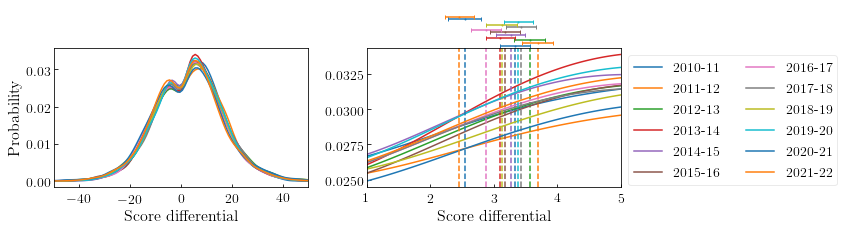

In [11]:
# Plot the distributions of score differentials for all seasons
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['font.size'] = 16
mpl.rcParams['legend.fontsize'] = 14

fig,ax = plt.subplots(2,2,figsize=(12,3.5), sharey=False, gridspec_kw={'height_ratios':[1.5,5]}, sharex='col')
xs = np.linspace(-50,50,100)
years = range(2011,2023)
for year in years:
    kernel = stats.gaussian_kde(vals[year])
    line, = ax[1,0].plot(xs, kernel(xs), label="$%i$-$%i$" % (year-1,year-2000))
    #ax[0].axvline(np.mean(vals[year]), ls='dashed', color=line.get_color())
ax[1,0].set_xlim(xs[0],xs[-1])
xs = np.linspace(1,5,100)
for year in years:
    kernel = stats.gaussian_kde(vals[year])
    line, = ax[1,1].plot(xs, kernel(xs), label="$%i$-$%i$" % (year-1,year-2000))
    ax[1,1].axvline(np.mean(vals[year]), ls='dashed', color=line.get_color())
    std_err = np.std(vals[year]) / np.sqrt(len(vals[year]))
    #ax[1,1].axvspan(np.mean(vals[year])-std_err, np.mean(vals[year])+std_err, alpha=0.15, color=line.get_color())
    ax[0,1].errorbar(np.mean(vals[year]), year, xerr=std_err, color=line.get_color(),
                         ls='', marker='o', markersize=1, capsize=2)
ax[1,1].set_xlim(xs[0],xs[-1])
ax[1,0].set_xlabel("${\\rm Score~differential}$")
ax[1,1].set_xlabel("${\\rm Score~differential}$")
ax[1,0].set_ylabel("${\\rm Probability}$")
ax[1,1].legend(loc = 'upper left', ncol=2, framealpha=0.4, bbox_to_anchor=(1.0, 1.0))
ax[0,0].set_visible(False)
ax[0,1].set_ylim(years[0]-1,years[-1]+4)
ax[0,1].set_yticks([])
ax[0,1].axis('off')
plt.tight_layout(h_pad=0)
#plt.savefig("../figs/score_differential.pdf")
plt.show()

/anaconda3/envs/astroconda/lib/python2.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


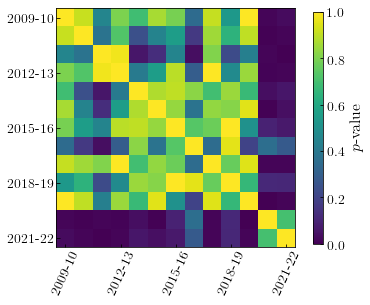

In [12]:
# KS Tests
vals = {}
years = range(2010,2023)
for year in years:
    vals[year] = df_inconf[year][df_inconf[year]['WLoc'] == 'H']['ScoreDifferential']
ks_result_stat, ks_result_pval = np.zeros((len(years),len(years))), np.zeros((len(years),len(years)))
for i in range(len(years)):
    y1 = years[i]
    for j in range(len(years)):
        y2 = years[j]
        ks_result_stat[i,j], ks_result_pval[i,j] = stats.ks_2samp(vals[y1].values,vals[y2].values)
fig,ax = plt.subplots(1,1,figsize=(5,4.5))
im = ax.imshow(ks_result_pval,vmin=0,vmax=1,extent=[years[0]-0.5,years[-1]+0.5,years[-1]+0.5,years[0]-0.5])
tick_years = [years[0] + 3*i for i in range(int(np.ceil(len(years)/3))+1)]
plt.xticks(tick_years,["$%i$-$%02d$" % (year-1,year-2000) for year in tick_years],rotation=65)
plt.yticks(tick_years,["$%i$-$%02d$" % (year-1,year-2000) for year in tick_years])
cbaxes = fig.add_axes([0.85, 0.22, 0.03, 0.715]) 
cb = plt.colorbar(im, cax=cbaxes, label='$p$-${\\rm value}$')
plt.tight_layout(rect=[0, 0, 0.85, 1.0])
#plt.savefig('../figs/kstest.pdf')
plt.show()

In [13]:
# LaTeX table of KS test results
for i in range(len(years)):
    line = "%s-%02d & " % (years[i]-1, years[i]-2000)
    for j in range(len(years)-2,len(years)):
        line += "%.3f" % ks_result_pval[i,j]
        if j == len(years)-1:
            line += " \\\\"
        else:
            line += " & "
    print line

2009-10 & 0.012 & 0.029 \\
2010-11 & 0.004 & 0.012 \\
2011-12 & 0.012 & 0.001 \\
2012-13 & 0.011 & 0.013 \\
2013-14 & 0.038 & 0.060 \\
2014-15 & 0.006 & 0.041 \\
2015-16 & 0.096 & 0.068 \\
2016-17 & 0.362 & 0.285 \\
2017-18 & 0.013 & 0.014 \\
2018-19 & 0.115 & 0.110 \\
2019-20 & 0.002 & 0.015 \\
2020-21 & 1.000 & 0.704 \\
2021-22 & 0.704 & 1.000 \\


In [14]:
# What percentage of games are won by the home team, and how many games were lost
#  due to the decrease in home court advantage?
homewins = 0
allgames = 0
for year in range(2010,2021):
    homewins += np.sum(vals[year]>0)
    allgames += len(vals[year])
print "2009-10 to 2019-20: ", float(homewins)/allgames
for year in range(2010,2023):
    print year, np.sum(vals[year]>0)/float(len(vals[year]))
    print "Games turned: ", (float(homewins)/allgames - np.sum(vals[year]>0)/float(len(vals[year]))) * len(vals[year])

2009-10 to 2019-20:  0.606286532268
2010 0.6145479265805575
Games turned:  -24.305022068471988
2011 0.6112266112266113
Games turned:  -14.257067875462383
2012 0.6075641915336571
Games turned:  -3.682214004532929
2013 0.6143527833668678
Games turned:  -24.053560777764424
2014 0.6048572366261897
Games turned:  4.355063819634821
2015 0.6013535288430552
Games turned:  15.307109626625135
2016 0.604494382022472
Games turned:  5.582548013837313
2017 0.593508997429306
Games turned:  39.763688417034274
2018 0.6112903225806452
Games turned:  -15.51174997017789
2019 0.5944919278252612
Games turned:  37.259155433615575
2020 0.6126716604244694
Games turned:  -20.45795061433858
2021 0.5767817781043351
Games turned:  80.3119408326374
2022 0.5794363580055745
Games turned:  86.69921269235357


# Change over time for each conference

In [15]:
# Summarize conference home court advantages in a new DataFrame
year_list = range(1985,2023)
df = pd.DataFrame(columns=np.concatenate([np.array(["year"]),df_conference_info['ConfAbbrev'].unique()]))
df["year"] = year_list
df = df.set_index("year")
for year in year_list:
    conf_list = df_inconf[year]['WTeamConf'].unique()
    for conf in conf_list:
        df[conf][year] = df_inconf[year][
            (df_inconf[year]['WTeamConf'] == conf) &
            (df_inconf[year]['WLoc'] == 'H')
        ]['ScoreDifferential'].mean()
# Since Pac10+Pac12 are the same and Big8+Big12 are the same
df['pac_tentwelve'] = df[['pac_ten','pac_twelve']].sum(axis=1)
df['big_eighttwelve'] = df[['big_eight','big_twelve']].sum(axis=1)

# Big conferences
df['power_five'] = df[['pac_tentwelve','big_ten','big_eighttwelve','sec','acc']].mean(axis=1)
df['group_of_five'] = df[['aac','cusa','mac','mwc','sun_belt']].mean(axis=1)

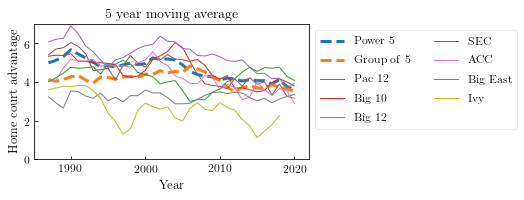

In [16]:
# Plot home court advantage over time with Nyear average
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['axes.labelsize'] = 13
mpl.rcParams['axes.titlesize'] = 14
mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 12

# Which conferences and groups to plot
conf_to_plot = ['pac_tentwelve','big_ten','big_eighttwelve','sec','acc','big_east','ivy']
group_to_plot = ['power_five','group_of_five']

fig,ax = plt.subplots(figsize=(7.5,3))
Nyear = 5
for group in group_to_plot:
    texname = df_conferences[df_conferences['ConfAbbrev'] == group]['TexName'].values[0]
    ax.plot(df.index, df[group].rolling(Nyear, center=True).mean(), label=texname, lw=3, ls='dashed')
for conf in conf_to_plot:
    texname = df_conferences[df_conferences['ConfAbbrev'] == conf]['TexName'].values[0]
    ax.plot(df.index, df[conf].rolling(Nyear, center=True).mean(), label=texname, lw=1)

ax.set_ylabel("${\\rm Home~court~advantage}$")
ax.set_xlabel("${\\rm Year}$")
ax.set_ylim(0,7)
ax.legend(loc = 'upper left', ncol=2, framealpha=0.4, bbox_to_anchor=(1.0, 1.0))
ax.set_title("${\\rm %i~year~moving~average}$" % Nyear)
ax.set_xlim(1985,2022)
plt.tight_layout()
#plt.savefig("../figs/homecourtadvantage_vs_year.pdf")
plt.show()

# Interactive version
Create an interactive version of the plot where you can 1) click on conferences to hide them and 2) change the time-frame for the moving average

In [17]:
from bokeh.plotting import output_notebook, output_file, show, figure, reset_output
from bokeh.layouts import row, column, gridplot
from bokeh.models import ColumnDataSource
from bokeh.models.widgets import Slider

In [18]:
output_file('../homecourtadvantage.html')

In [24]:
# Pre-compute the rolling averages
conf_to_plot = ['pac_tentwelve','big_ten','big_eighttwelve','sec','acc',
                'aac','mac','mwc','cusa','sun_belt','big_east','ovc','ivy']
for Nyear in range(1,11):
    for conf in conf_to_plot:
        df[conf+'_rollavg' + str(Nyear)] = df[conf].rolling(Nyear, center=True).mean()
for Nyear in range(1,11):
    for conf in ['power_five', 'group_of_five']:
        df[conf+'_rollavg' + str(Nyear)] = df[conf].rolling(Nyear, center=True).mean()
display(df.head())

,wac,ovc,sec,swac,ind,ecacs,southern,pac_ten,a_sun,swc,...,pac_tentwelve_rollavg6,big_eighttwelve_rollavg6,pac_tentwelve_rollavg7,big_eighttwelve_rollavg7,pac_tentwelve_rollavg8,big_eighttwelve_rollavg8,pac_tentwelve_rollavg9,big_eighttwelve_rollavg9,pac_tentwelve_rollavg10,big_eighttwelve_rollavg10
year,,,,,,,,,,,,,,,,,,,,,
1985,4.34177,2.25424,5.20652,5.01754,2.7375,3.03448,1.71831,2.93333,4.2459,2.68056,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1986,4.21053,4.05172,5.55914,4.44643,3.28889,NaN,3.68493,5.18889,3.53226,1.30556,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1987,3.61842,5.66667,4.44944,4.58929,5.4375,NaN,2.83333,3.01075,3.1573,3.11111,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1988,5.77027,3.4918,6.43956,6.10169,6.66129,NaN,6.45833,4.74194,4.86364,5.06944,...,4.003644,6.175794,4.345981,6.186395,NaN,NaN,NaN,NaN,NaN,NaN
1989,2.71622,3.4,5.3587,2.47458,4.06757,NaN,2.78571,4.22222,3.75269,4.84722,...,4.581422,6.220238,4.571377,6.474490,4.366622,6.413095,4.382704,6.164815,NaN,NaN


In [25]:
# Add non-LaTeX names for the Bokeh plot
conf_bokeh_names = {
    'a_sun': "Atlantic Sun Conference",
    'a_ten': "Atlantic 10 Conference",
    'aac': "AAC",  #"${\\rm American~Athletic~Conference}$",
    'acc': "ACC",
    'aec': "American East Conference",
    'asc': "American South Conference",
    'awc': "American West Conference",
    'big_east': "Big East",
    'big_eight': "Big 8 (old)",
    'big_sky': "Big Sky Conference",
    'big_south': "Big South Conference",
    'big_ten': "Big 10",
    'big_twelve': "Big 12 (old)",
    'big_west': "Big West",
    'mac': "MAC",
    'ovc': "OVC",  #"${\\rm Ohio~Valley~Conference}$",
    'pac_tentwelve': "Pac 12",
    'sec': "SEC",
    'big_eighttwelve': "Big 12",
    'ivy': "Ivy",
    'cusa': "C-USA",
    'mwc': "MWC",
    'sun_belt': "Sun Belt",
    'power_five': "Power Five",
    'group_of_five': "Group of Five"
}

df_conferences['BokehName'] = ""
for conf in conf_bokeh_names.keys():
    index = df_conferences.index[df_conferences['ConfAbbrev'] == conf].tolist()[0]
    df_conferences.loc[index,'BokehName'] = conf_bokeh_names[conf]
display(df_conferences.head())

,ConfAbbrev,Description,TexName,BokehName
0,a_sun,Atlantic Sun Conference,${\rm Atlantic~Sun~Conference}$,Atlantic Sun Conference
1,a_ten,Atlantic 10 Conference,${\rm Atlantic~10~Conference}$,Atlantic 10 Conference
2,aac,American Athletic Conference,${\rm AAC}$,AAC
3,acc,Atlantic Coast Conference,${\rm ACC}$,ACC
4,aec,America East Conference,${\rm American~East~Conference}$,American East Conference


In [26]:
from bokeh.palettes import Category10, Category20
from bokeh.models import Legend, Title, CustomJS

# Set up the initial data
Nyear = 3
conf_to_plot = [
    'pac_tentwelve','big_ten','big_eighttwelve','sec','acc',
    'aac','mac','mwc','cusa','sun_belt',
    'big_east','ovc','ivy',]
conf_group_to_plot = ['power_five','group_of_five']
for conf in conf_to_plot:
    df[conf+'_toplot'] = df[conf+'_rollavg'+str(Nyear)]
for conf in conf_group_to_plot:
    df[conf+'_toplot'] = df[conf+'_rollavg'+str(Nyear)]
source = ColumnDataSource(df)

# Create the figure
TOOLS = "pan,wheel_zoom,reset"
p = figure(plot_width=1000, plot_height=400, tools=TOOLS, toolbar_location=None, x_range=(1985,2022), y_range=(0, 7))
p.xaxis.axis_label = "Season"
p.yaxis.axis_label = "Home court advantage (points)"

# Add individual conferences and conference groups
lines_group, points_group = {}, {}
for conf, color in zip(conf_group_to_plot, Category10[10]):
    colname = conf + '_toplot'
    lines_group[conf] = p.line('year', colname, source=source, color=color, muted_alpha=0.05, line_width=5)

lines, points = {}, {}
for conf, color in zip(conf_to_plot, Category20[len(conf_to_plot)]):
    colname = conf + '_toplot'
    points[conf] = p.scatter('year', colname, fill_color=color, line_color='grey', size=8, fill_alpha=0.8, source=source, muted_alpha=0.05)
    lines[conf] = p.line('year', colname, source=source, color=color, muted_alpha=0.05)

# Add the legends
legend_conf_title = p.circle(0, 0, size=0.00000001, color= "#ffffff")
legend_conf = Legend(
    items=[("Conferences", [legend_conf_title])] + [
        (df_conferences[df_conferences['ConfAbbrev']==conf]['BokehName'].values[0],
         [lines[conf], points[conf]]) for conf in conf_to_plot],
    location='top_left',
    orientation="vertical",
    click_policy='mute'
)
legend_conf_group_title = p.circle(0, 0, size=0.00000001, color= "#ffffff")
legend_conf_group = Legend(
    items=[("Groups", [legend_conf_title])] + [
        (df_conferences[df_conferences['ConfAbbrev']==conf]['BokehName'].values[0],
         [lines_group[conf]]) for conf in conf_group_to_plot],
    location='top_left',
    orientation="vertical",
    click_policy='mute'
)
p.add_layout(legend_conf, 'right')
p.add_layout(legend_conf_group, 'right')

# Slider for choosing N year moving average
slider = Slider(start=1, end=10, value=3, step=1, title="N year moving average")
callback = CustomJS(
    args=dict(source=source, slider=slider, conf_list=conf_to_plot, conf_group_list=conf_group_to_plot),
    code="""
        // Get the data values and the slider values
        const data = source.data;
        const Nyear = slider.value;
        var conf;
        for (var i = 0; i < conf_list.length; i++) {
            conf = conf_list[i];
            data[conf+'_toplot'] = data[conf+'_rollavg'+Nyear];
        }
        for (var i = 0; i < conf_group_list.length; i++) {
            conf = conf_group_list[i];
            data[conf+'_toplot'] = data[conf+'_rollavg'+Nyear];
        }
                
        // Need this to send back the updated values
        source.change.emit();
    """
)
slider.js_on_change('value', callback)

layout = column(slider, p)
show(layout)